# Neural-Fly: Domain Adversarially Invariant Meta Learning

This script loads quadrotor flight data in different wind conditions, trains a wind invariant representation of the unmodeled aerodynamics, and tests the performance of the model when adapting to new data in different wind conditions. 

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os 
import utils
import mlmodel

from datetime import datetime
import re

/home/hcr/anaconda3/envs/rina/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845206/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
import sys
if sys.platform == 'win32':
    NUM_WORKERS = 0 # Windows does not support multiprocessing
else:
    NUM_WORKERS = 2
print('running on ' + sys.platform + ', setting ' + str(NUM_WORKERS) + ' workers')

running on linux, setting 2 workers


## Load the data and create some simple visualizations

In [3]:
dim_a = 3
features = ['q', 'q_dot', 'tau']
label = 'tau_residual_m'

labels = ["FR_hip", "FR_knee", "FR_foot", "FL_hip", "FL_knee", "FL_foot",
          "RR_hip", "RR_knee", "RR_foot", "RL_hip", "RL_knee", "RL_foot"]

# Training data collected from the neural-fly drone
dataset = 'rina' 
# dataset_folder = '/home/hcr/Research/DARoSLab/DARoS-Core/lcm_converted_log/training_data/'
dataset_folder = '/home/hcr/Research/DARoSLab/DARoS-Core/lcm_converted_log/03_04_2024/unitree_estimate/training_data/'


now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y%H:%M:%S")
date_time = re.sub('[^0-9a-zA-Z]+', '_', date_time)

date_time += "_m"

cwd = os.getcwd()

output_path_base = os.path.join(cwd, "training_results", date_time)

if not os.path.exists(output_path_base):
    os.makedirs(output_path_base)

print(output_path_base)

# # Training data collected from an intel aero drone
# dataset = 'neural-fly-transfer'
# dataset_folder = 'data/training-transfer'
# hover_pwm = 910 # mean hover pwm for neural-fly drone
# intel_hover_pwm = 1675 # mean hover pwm for intel-aero drone
# hover_pwm_ratio = hover_pwm / intel_hover_pwm # scaling ratio from system id

modelname = f"{dataset}_dim-a-{dim_a}_{'-'.join(features)}" # 'intel-aero_fa-num-Tsp_v-q-pwm'

print(modelname)

/home/hcr/Research/DARoSLab/rina/training_results/05_16_202413_27_47_m
rina_dim-a-3_q-q_dot-tau


In [4]:
RawData = utils.load_data(dataset_folder)
Data = utils.format_data(RawData, features=features, output=label)

print("\n-----------------------------------------------\n")

testdata_folder = "/home/hcr/Research/DARoSLab/DARoS-Core/lcm_converted_log/03_04_2024/unitree_estimate/eval_data/"
RawData = utils.load_data(testdata_folder) # expnames='(baseline_)([0-9]*|no)wind'
TestData = utils.format_data(RawData, features=features, output=label) # wind condition label, C, will not make sense for this data - that's okay since C is only used in the training process

['0lb.csv', '5lb.csv', '10lb.csv']
0lb
5lb
10lb

-----------------------------------------------

['0lb.csv', '5lb.csv', '10lb.csv']
0lb
5lb
10lb


In [5]:
training_data_images = os.path.join(output_path_base, "training_data_images")
test_data_images = os.path.join(output_path_base, "test_data_images")

if not os.path.exists(training_data_images):
    os.makedirs(training_data_images)

if not os.path.exists(test_data_images):
    os.makedirs(test_data_images)

for data in Data:
    utils.plot_subdataset(data, features, labels, os.path.join(training_data_images, "{:s}.png".format(data.meta['condition'])), title_prefix="(Training data)")

for data in TestData:
    utils.plot_subdataset(data, features, labels, os.path.join(test_data_images, "{:s}.png".format(data.meta['condition'])), title_prefix="(Testing Data)")

## Initialize some other hyperparameters

In [6]:
options = {}
options['dim_x'] = Data[0].X.shape[1]
options['dim_y'] = Data[0].Y.shape[1]
options['num_c'] = len(Data)
print('dims of (x, y) are', (options['dim_x'], options['dim_y']))
print('there are ' + str(options['num_c']) + ' different conditions')

dims of (x, y) are (36, 12)
there are 3 different conditions


In [7]:
# Set hyperparameters
options['features'] = features
options['dim_a'] = dim_a
options['loss_type'] = 'crossentropy-loss'

options['shuffle'] = True # True: shuffle trajectories to data points
options['K_shot'] = 32 # number of K-shot for least square on a
options['phi_shot'] = 256 # batch size for training phi

options['alpha'] = 0.01 # adversarial regularization loss
options['learning_rate'] = 5e-4
options['frequency_h'] = 2 # how many times phi is updated between h updates, on average
options['SN'] = 2. # maximum single layer spectral norm of phi
options['gamma'] = 10. # max 2-norm of a
options['num_epochs'] = 2000


options['output_path'] = output_path_base

# Dataset Generation

The adaptation dataset will be used to update $a$ in each training loop.
The training dataset will be used to train $\phi$ in each training loop.

In [8]:
# Trainset = []
# Adaptset = []
Trainloader = []
Adaptloader = []
for i in range(options['num_c']):
    fullset = mlmodel.MyDataset(Data[i].X, Data[i].Y, Data[i].C)
    
    l = len(Data[i].X)
    if options['shuffle']:
        trainset, adaptset = random_split(fullset, [int(2/3*l), l-int(2/3*l)])
    else:
        trainset = mlmodel.MyDataset(Data[i].X[:int(2/3*l)], Data[i].Y[:int(2/3*l)], Data[i].C) 
        adaptset = mlmodel.MyDataset(Data[i].X[int(2/3*l):], Data[i].Y[int(2/3*l):], Data[i].C)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=options['phi_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
    adaptloader = torch.utils.data.DataLoader(adaptset, batch_size=options['K_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
   
    # Trainset.append(trainset)
    # Adaptset.append(adaptset)
    Trainloader.append(trainloader) # for training phi
    Adaptloader.append(adaptloader) # for LS on a

# Domain Adversarially Invariant Meta Learning

Assume the state $x\in\mathbb{R}^n$ and $c$ is hidden state used to represent changing environment. We are interested in learning some function $f(x(t),c(t))$. $f(x(t),c(t))$ can be separated into three terms: $$f(x(t),c(t))=\phi(x(t))a(c(t))+d(t),$$
where $\phi(x(t))$ captures the $c$-variant part and $a(c(t))\in\mathbb{R}^m$ is implicitly a function of the hidden state $c(t)$. Finally, $d(t)$ is the residual noise term.

We want to learn $\phi(x)$ such that it doesn't include any information about $c$. To reach this goal, we introduce another neural network $h$ where $h(\phi(x))$ tries to predict $c$.

The loss function is given as
$$\max_h\min_{\phi, \left\{a_{c_j}\right\}_j}\sum_{j}\sum_{i}\left\|\phi(x^{(i)}_{c_j})a_{c_j}-f(x^{(i)}_{c_j},c_j)\right\|^2-\alpha\cdot\text{CrossEntropy}\left(h(\phi(x^{(i)}_{c_j})),j\right)$$
Note that the $\text{CrossEntropy-loss}$ will not require physical encoding of $c_j$ in training, only a label for $c$ that corresponds to the subdataset (that is, the label $c$ has no physical meaning).

# Initialize the models

In [9]:
# Store the model class definition in an external file so they can be referenced outside this script
phi_net = mlmodel.Phi_Net(options)
h_net = mlmodel.H_Net_CrossEntropy(options)

In [10]:
criterion = nn.MSELoss()
criterion_h = nn.CrossEntropyLoss()
optimizer_h = optim.Adam(h_net.parameters(), lr=options['learning_rate'])
optimizer_phi = optim.Adam(phi_net.parameters(), lr=options['learning_rate'])

# Meta-Training Algorithm

**Step 0: sample $c$, and sample $B+K$ data points in correponding subdataset $\{x_i,c,f(x_i,c)\}_{i}$**

**Step 1: estimate $a$ using least-square**

$K$ data points (sampled from the same wind condition $c$) are used to compute $a$ using least-squares, i.e., adaptation:
$$
\underbrace{
    \begin{bmatrix}
        \phi(x_1) \\ \phi(x_2) \\ \vdots \\ \phi(x_K) 
    \end{bmatrix}}
    _{\Phi\in\mathbb{R}^{K\times \dim(a)}}
\cdot
\underbrace{
    \begin{bmatrix}
        a_1 & \cdots & a_{\dim(y)} 
    \end{bmatrix}}
    _{a\in\mathbb{R}^{\dim(a)\times \dim(y)}}
=
\underbrace{
    \begin{bmatrix}
        f_1(x_1) & \cdots & f_{\dim(y)}(x_1) \\ f_1(x_2) & \cdots & f_{\dim(y)}(x_2) \\ \vdots & \vdots & \vdots\\ f_1(x_K) & \cdots & f_{\dim(y)}(x_K) 
    \end{bmatrix}}
    _{Y\in\mathbb{R}^{K\times \dim(y)}}
$$

The least square solution is given by
$$a=(\Phi^\top\Phi)^{-1}\Phi^\top Y$$
Normalization on $a$ is implemented to avoid ambiguity of $\phi(x)a$ (since $\phi(x)a=(0.1\phi(x))\cdot(10a)$):
$$a\leftarrow \gamma\cdot\frac{a}{\|a\|_F},\quad\text{if}\,\,\|a\|_F>\gamma$$
Note that $a$ is an implicit function of $\phi$.

**Step 2: fix $h$ and train $\phi$**

With this $a$, another $B$ data points (with same $c$) are used for gradient descent with loss
$$\mathcal{L}(\phi)=\|f(x)-\phi(x)a\|_2^2-\alpha\cdot\|h(\phi(x))-c\|_2^2$$

**Step 3: fix $\phi$ and train discriminator $h$**

Finally, these $B$ data points are used again for gradient descent on $h$ with loss
$$\mathcal{L}(h)=\|h(\phi(x))-c\|_2^2$$
We may run this step less frequently than step 2, to improve stability in training (a trick from GAN).

In [11]:
model_save_freq = 50 # How often to save the model

# Create some arrays to save training statistics
Loss_f = [] # combined force prediction loss
Loss_c = [] # combined adversarial loss

# Loss for each subdataset 
Loss_test_nominal = [] # loss without any learning
Loss_test_mean = [] # loss with mean predictor
Loss_test_phi = [] # loss with NN
for i in range(len(TestData)):
    Loss_test_nominal.append([])
    Loss_test_mean.append([])
    Loss_test_phi.append([])

# Training!
for epoch in range(options['num_epochs']):
    # Randomize the order in which we train over the subdatasets
    arr = np.arange(options['num_c'])
    np.random.shuffle(arr)

    # Running loss over all subdatasets
    running_loss_f = 0.0
    running_loss_c = 0.0

    for i in arr:
        with torch.no_grad():
            adaptloader = Adaptloader[i]
            kshot_data = next(iter(adaptloader))
            trainloader = Trainloader[i]
            data = next(iter(trainloader))
        
        optimizer_phi.zero_grad()
        
        '''
        Least-square to get $a$ from K-shot data
        '''
        X = kshot_data['input'] # K x dim_x
        Y = kshot_data['output'] # K x dim_y
        Phi = phi_net(X) # K x dim_a
        Phi_T = Phi.transpose(0, 1) # dim_a x K
        A = torch.inverse(torch.mm(Phi_T, Phi)) # dim_a x dim_a
        a = torch.mm(torch.mm(A, Phi_T), Y) # dim_a x dim_y
        if torch.norm(a, 'fro') > options['gamma']:
            a = a / torch.norm(a, 'fro') * options['gamma']
            
        '''
        Batch training \phi_net
        '''
        inputs = data['input'] # B x dim_x
        labels = data['output'] # B x dim_y
        
        c_labels = data['c'].type(torch.long)
            
        # forward + backward + optimize
        outputs = torch.mm(phi_net(inputs), a)
        loss_f = criterion(outputs, labels)
        temp = phi_net(inputs)
        
        loss_c = criterion_h(h_net(temp), c_labels)
            
        loss_phi = loss_f - options['alpha'] * loss_c
        loss_phi.backward()
        optimizer_phi.step()
        
        '''
        Discriminator training
        '''
        if np.random.rand() <= 1.0 / options['frequency_h']:
            optimizer_h.zero_grad()
            temp = phi_net(inputs)
            
            loss_c = criterion_h(h_net(temp), c_labels)
            
            loss_h = loss_c
            loss_h.backward()
            optimizer_h.step()
        
        '''
        Spectral normalization
        '''
        if options['SN'] > 0:
            for param in phi_net.parameters():
                M = param.detach().numpy()
                if M.ndim > 1:
                    s = np.linalg.norm(M, 2)
                    if s > options['SN']:
                        param.data = param / s * options['SN']
         
        running_loss_f += loss_f.item()
        running_loss_c += loss_c.item()
    
    # Save statistics
    Loss_f.append(running_loss_f / options['num_c'])
    Loss_c.append(running_loss_c / options['num_c'])
    if epoch % 10 == 0:
        print('[%d] loss_f: %.2f loss_c: %.2f' % (epoch + 1, running_loss_f / options['num_c'], running_loss_c / options['num_c']))
        
    with torch.no_grad():
        for j in range(len(TestData)):
            loss_nominal, loss_mean, loss_phi = mlmodel.error_statistics(TestData[j].X, TestData[j].Y, phi_net, h_net, options=options)
            Loss_test_nominal[j].append(loss_nominal)
            Loss_test_mean[j].append(loss_mean)
            Loss_test_phi[j].append(loss_phi)

    if epoch % model_save_freq == 0:
        mlmodel.save_model(phi_net=phi_net, h_net=h_net, modelname=modelname + '-epoch-' + str(epoch), options=options)

mlmodel.save_model(phi_net=phi_net, h_net=h_net, modelname=modelname + '-epoch-' + str(options["num_epochs"]), options=options)

<>:47: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_123120/2032337320.py:47: SyntaxWarning: invalid escape sequence '\p'
  '''


[1] loss_f: 91.48 loss_c: 1.10
[11] loss_f: 64.21 loss_c: 1.09
[21] loss_f: 48.10 loss_c: 1.10
[31] loss_f: 43.13 loss_c: 1.09
[41] loss_f: 32.89 loss_c: 1.14
[51] loss_f: 23.06 loss_c: 1.15
[61] loss_f: 23.79 loss_c: 1.17
[71] loss_f: 27.60 loss_c: 1.17
[81] loss_f: 29.69 loss_c: 1.18
[91] loss_f: 26.88 loss_c: 1.18
[101] loss_f: 23.47 loss_c: 1.16
[111] loss_f: 31.50 loss_c: 1.15
[121] loss_f: 21.34 loss_c: 1.13
[131] loss_f: 34.14 loss_c: 1.11
[141] loss_f: 21.82 loss_c: 1.11
[151] loss_f: 18.65 loss_c: 1.11
[161] loss_f: 25.09 loss_c: 1.12
[171] loss_f: 33.13 loss_c: 1.13
[181] loss_f: 24.79 loss_c: 1.12
[191] loss_f: 23.17 loss_c: 1.11


Traceback (most recent call last):
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-g9tpmgd5'


[201] loss_f: 33.88 loss_c: 1.10
[211] loss_f: 30.06 loss_c: 1.09
[221] loss_f: 23.67 loss_c: 1.09
[231] loss_f: 25.11 loss_c: 1.09
[241] loss_f: 26.76 loss_c: 1.09
[251] loss_f: 23.98 loss_c: 1.10
[261] loss_f: 27.32 loss_c: 1.09
[271] loss_f: 23.54 loss_c: 1.09
[281] loss_f: 24.81 loss_c: 1.09
[291] loss_f: 24.68 loss_c: 1.09
[301] loss_f: 31.36 loss_c: 1.09
[311] loss_f: 23.76 loss_c: 1.08
[321] loss_f: 29.70 loss_c: 1.08
[331] loss_f: 27.69 loss_c: 1.08
[341] loss_f: 16.90 loss_c: 1.10
[351] loss_f: 17.03 loss_c: 1.09
[361] loss_f: 26.76 loss_c: 1.09
[371] loss_f: 25.73 loss_c: 1.09
[381] loss_f: 28.12 loss_c: 1.09
[391] loss_f: 36.29 loss_c: 1.08
[401] loss_f: 20.10 loss_c: 1.08
[411] loss_f: 21.70 loss_c: 1.08
[421] loss_f: 25.59 loss_c: 1.08
[431] loss_f: 22.85 loss_c: 1.07
[441] loss_f: 24.87 loss_c: 1.08
[451] loss_f: 21.28 loss_c: 1.08
[461] loss_f: 19.72 loss_c: 1.07
[471] loss_f: 18.80 loss_c: 1.06
[481] loss_f: 24.91 loss_c: 1.08
[491] loss_f: 22.12 loss_c: 1.08
[501] loss

Traceback (most recent call last):
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-iwkl763b'


[521] loss_f: 28.55 loss_c: 1.06
[531] loss_f: 23.83 loss_c: 1.05
[541] loss_f: 22.77 loss_c: 1.07
[551] loss_f: 16.47 loss_c: 1.06
[561] loss_f: 27.88 loss_c: 1.05


Traceback (most recent call last):
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-d1t1_cse'


[571] loss_f: 23.09 loss_c: 1.06
[581] loss_f: 22.75 loss_c: 1.04
[591] loss_f: 14.98 loss_c: 1.05
[601] loss_f: 20.20 loss_c: 1.04
[611] loss_f: 24.21 loss_c: 1.04
[621] loss_f: 22.82 loss_c: 1.04


Traceback (most recent call last):
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-26dddjg7'


[631] loss_f: 18.34 loss_c: 1.03
[641] loss_f: 24.44 loss_c: 1.04
[651] loss_f: 19.44 loss_c: 1.04
[661] loss_f: 22.97 loss_c: 1.03
[671] loss_f: 24.59 loss_c: 1.04
[681] loss_f: 23.57 loss_c: 1.03
[691] loss_f: 15.22 loss_c: 1.03
[701] loss_f: 19.83 loss_c: 1.03
[711] loss_f: 20.86 loss_c: 1.04


Traceback (most recent call last):
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-_72l93qm'


[721] loss_f: 24.82 loss_c: 1.03
[731] loss_f: 22.88 loss_c: 1.03
[741] loss_f: 24.02 loss_c: 1.01
[751] loss_f: 20.61 loss_c: 1.02
[761] loss_f: 23.62 loss_c: 1.01
[771] loss_f: 18.41 loss_c: 1.00
[781] loss_f: 20.50 loss_c: 1.02
[791] loss_f: 22.17 loss_c: 1.04
[801] loss_f: 25.51 loss_c: 1.02
[811] loss_f: 22.58 loss_c: 1.00
[821] loss_f: 21.77 loss_c: 1.00
[831] loss_f: 21.03 loss_c: 1.01
[841] loss_f: 20.66 loss_c: 0.99
[851] loss_f: 23.59 loss_c: 1.00
[861] loss_f: 23.09 loss_c: 0.99
[871] loss_f: 27.45 loss_c: 1.02


Traceback (most recent call last):
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-k1sjo1xq'


[881] loss_f: 18.99 loss_c: 1.01
[891] loss_f: 24.88 loss_c: 1.00


Traceback (most recent call last):
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-tluxalvs'


[901] loss_f: 19.94 loss_c: 0.98
[911] loss_f: 14.68 loss_c: 1.00
[921] loss_f: 18.41 loss_c: 1.01
[931] loss_f: 18.88 loss_c: 0.99
[941] loss_f: 16.73 loss_c: 1.00
[951] loss_f: 30.01 loss_c: 0.99
[961] loss_f: 25.20 loss_c: 1.00
[971] loss_f: 21.16 loss_c: 1.01
[981] loss_f: 21.53 loss_c: 1.01
[991] loss_f: 21.90 loss_c: 1.00
[1001] loss_f: 15.74 loss_c: 1.01
[1011] loss_f: 16.09 loss_c: 1.00
[1021] loss_f: 18.92 loss_c: 0.98
[1031] loss_f: 15.81 loss_c: 0.98
[1041] loss_f: 24.17 loss_c: 0.96
[1051] loss_f: 32.14 loss_c: 0.99
[1061] loss_f: 20.06 loss_c: 0.98
[1071] loss_f: 24.23 loss_c: 0.98
[1081] loss_f: 14.53 loss_c: 0.96
[1091] loss_f: 17.39 loss_c: 0.97
[1101] loss_f: 20.40 loss_c: 0.98
[1111] loss_f: 30.46 loss_c: 0.95
[1121] loss_f: 22.34 loss_c: 0.96
[1131] loss_f: 23.91 loss_c: 0.94
[1141] loss_f: 23.39 loss_c: 0.97
[1151] loss_f: 27.38 loss_c: 0.95
[1161] loss_f: 23.40 loss_c: 0.97
[1171] loss_f: 15.48 loss_c: 0.94
[1181] loss_f: 23.27 loss_c: 0.95
[1191] loss_f: 19.93 los

Traceback (most recent call last):
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-odp4qfd7'


[1621] loss_f: 22.29 loss_c: 0.89
[1631] loss_f: 18.45 loss_c: 0.91
[1641] loss_f: 28.29 loss_c: 0.92
[1651] loss_f: 18.97 loss_c: 0.90
[1661] loss_f: 18.65 loss_c: 0.90
[1671] loss_f: 16.45 loss_c: 0.90
[1681] loss_f: 20.12 loss_c: 0.90
[1691] loss_f: 18.99 loss_c: 0.90
[1701] loss_f: 20.46 loss_c: 0.90
[1711] loss_f: 19.35 loss_c: 0.89
[1721] loss_f: 19.59 loss_c: 0.91
[1731] loss_f: 24.51 loss_c: 0.88
[1741] loss_f: 20.53 loss_c: 0.89
[1751] loss_f: 23.64 loss_c: 0.88
[1761] loss_f: 15.51 loss_c: 0.87
[1771] loss_f: 15.76 loss_c: 0.89
[1781] loss_f: 23.64 loss_c: 0.90
[1791] loss_f: 19.19 loss_c: 0.90
[1801] loss_f: 15.47 loss_c: 0.94
[1811] loss_f: 14.85 loss_c: 0.90
[1821] loss_f: 17.10 loss_c: 0.90
[1831] loss_f: 19.62 loss_c: 0.93
[1841] loss_f: 20.46 loss_c: 0.94
[1851] loss_f: 13.91 loss_c: 0.91
[1861] loss_f: 19.11 loss_c: 0.90
[1871] loss_f: 20.30 loss_c: 0.91
[1881] loss_f: 15.21 loss_c: 0.92
[1891] loss_f: 21.71 loss_c: 0.89


Traceback (most recent call last):
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/hcr/anaconda3/envs/rina/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-4_hs9p8g'


[1901] loss_f: 16.95 loss_c: 0.91
[1911] loss_f: 19.68 loss_c: 0.91
[1921] loss_f: 21.97 loss_c: 0.88
[1931] loss_f: 25.10 loss_c: 0.90
[1941] loss_f: 16.89 loss_c: 0.90
[1951] loss_f: 16.47 loss_c: 0.88
[1961] loss_f: 25.66 loss_c: 0.87
[1971] loss_f: 19.67 loss_c: 0.91
[1981] loss_f: 16.61 loss_c: 0.90
[1991] loss_f: 20.21 loss_c: 0.88


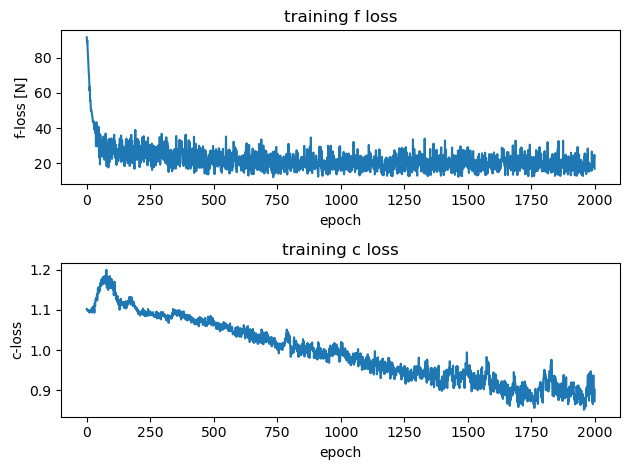

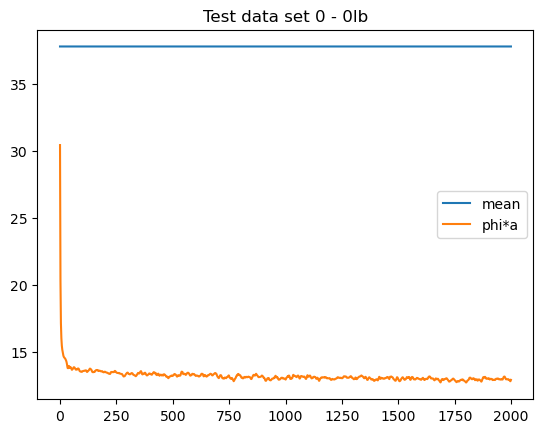

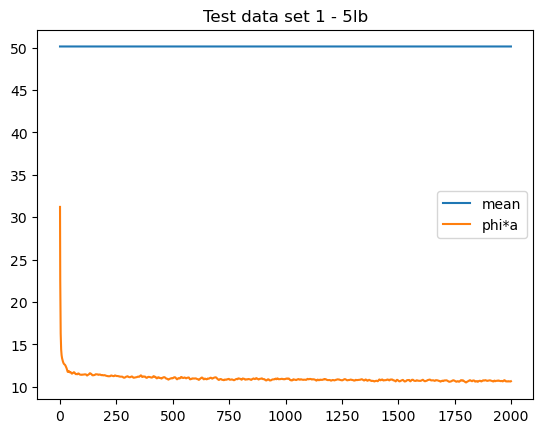

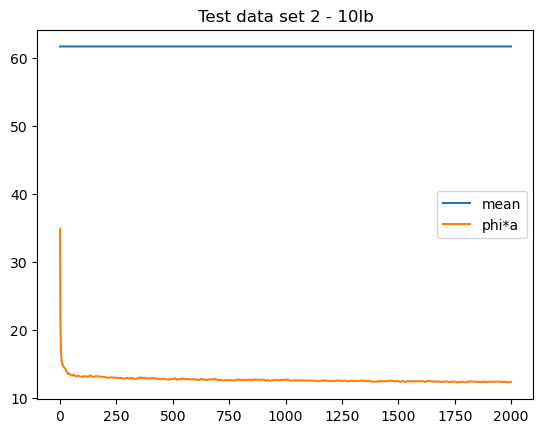

In [12]:
plt.subplot(2, 1, 1)
plt.plot(Loss_f)
plt.xlabel('epoch')
plt.ylabel('f-loss [N]')
plt.title('training f loss')
plt.subplot(2, 1, 2)
plt.plot(Loss_c)
plt.title('training c loss')
plt.xlabel('epoch')
plt.ylabel('c-loss')
plt.tight_layout()

for j in range(len(TestData)):
    plt.figure()
    # plt.plot(Loss_test_nominal[j], label='nominal')
    plt.plot(Loss_test_mean[j], label='mean')
    plt.plot(np.array(Loss_test_phi[j]), label='phi*a')
    # plt.plot(np.array(Loss_test_exp_forgetting[j]), label='exp forgetting')
    plt.legend()
    plt.title(f'Test data set {j} - {TestData[j].meta["condition"]}')

plt.show()

In [19]:
# Choose final model
# stopping_epoch = 200
# options['num_epochs'] = stopping_epoch

model_path = os.path.join(options["output_path"], "models", (modelname + '-epoch-' + str(options["num_epochs"])))
# model_path = os.path.join("/home/hcr/Research/DARoSLab/rina/training_results/04_02_202415_31_57/models", (modelname + '-epoch-' + str(2000)))
final_model = mlmodel.load_model(modelname = model_path)

In [21]:
phi_net = final_model.phi
h_net = final_model.h

eval_adapt_start = 0
eval_adapt_end = 2500
eval_val_start = 2500
eval_val_end = 5000

vis_output_path_prefix_training_data = os.path.join(options["output_path"], "eval_iamges", "training")
vis_output_path_prefix_testing_data = os.path.join(options["output_path"], "eval_iamges", "testing")

# vis_output_path_prefix_training_data = os.path.join("/home/hcr/Research/DARoSLab/rina/training_results/04_02_202415_31_57/eval_images/training")
# vis_output_path_prefix_testing_data = os.path.join("/home/hcr/Research/DARoSLab/rina/training_results/04_02_202415_31_57/eval_images/testing")

Plot the measured aerodynamic force, labeled ground truth (gt), along with the region used for adapation (adapt), and the predicted region (val)

In [22]:
for i, data in enumerate(Data):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    file_name = "{:s}.png".format(data.meta['condition'])
    mlmodel.vis_validation(t=data.meta['steps'], x=data.X, y=data.Y, phi_net=phi_net, 
                           h_net=h_net, idx_adapt_start=eval_adapt_start, idx_adapt_end=eval_adapt_end, 
                           idx_val_start=eval_val_start, idx_val_end=eval_val_end, c=Data[i].C, options=options, 
                           output_path_prefix=vis_output_path_prefix_training_data, output_name=file_name)

------------------------------
0lb:
a = [[ 0.22302943  0.23226283  0.4327126   0.26066399 -0.18979032 -0.59706679
  -0.19310555 -0.22886764 -0.81370228 -0.13990722  0.25755196  0.74642216]
 [ 0.24991236 -0.52084898  0.89836579  0.07899623  0.32824344  0.56613338
   0.0575629   0.28277343  0.0711258  -0.28915059 -0.48514074  0.44547453]
 [-1.09845244 -7.04746989  0.03806313  2.7256996   1.77523621  0.0251402
  -1.0143582   1.69342975 -7.86599974 -0.46156633 -6.75909321 -8.5316936 ]]
|a| = 15.819052801045743
------------------------------
5lb:
a = [[ 0.21627426  0.13167924  0.54019013  0.25355726 -0.16069765 -0.63775488
  -0.22077004 -0.15023944 -0.84799778 -0.18462981  0.13272905  0.69503818]
 [ 0.24310162  0.02804496  0.65017739 -0.02264991  0.07917948  0.30419338
   0.06584022  0.08313866  0.30518629 -0.2299014  -0.07480281  0.69342823]
 [-0.86412295 -1.46579305 -3.47146919  1.87452686 -0.13287058 -3.24306554
  -1.25066063  0.34282211 -5.65376708  0.65832583 -1.92227217 -5.91109029]]


<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

In [23]:
for data in Data:
    image_name = "{:s}_errors_hist.png".format(data.meta['condition'])
    error_1, error_2, error_3 = mlmodel.error_statistics_hist(data.X, data.Y, phi_net, h_net, options, vis_output_path_prefix_training_data, image_name)
    print('**** c =', str(data.C), ':', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** c = 0 : 0lb ****
Before learning: MSE is  59.77
Mean predictor: MSE is  33.71
After learning phi(x): MSE is  9.83

**** c = 1 : 5lb ****
Before learning: MSE is  99.12
Mean predictor: MSE is  50.92
After learning phi(x): MSE is  10.54

**** c = 2 : 10lb ****
Before learning: MSE is  127.47
Mean predictor: MSE is  65.37
After learning phi(x): MSE is  13.88



## Test Data Error Analysis

In [24]:
for i, data in enumerate(TestData):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    print(len(data.X))
    file_name = "{:s}.png".format(data.meta['condition'])
    mlmodel.vis_validation(t=data.meta['steps'], x=data.X, y=data.Y, phi_net=phi_net, h_net=h_net, 
                           idx_adapt_start=eval_adapt_start, idx_adapt_end=eval_adapt_end, 
                           idx_val_start=eval_val_start, idx_val_end=eval_val_end, c=Data[i].C, options=options,
                           output_path_prefix=vis_output_path_prefix_testing_data, output_name=file_name)

------------------------------
0lb:
17645
a = [[ 0.20322743  0.15268319  0.47722395  0.26146267 -0.21106673 -0.60207011
  -0.19453572 -0.22840031 -0.86169776 -0.13528294  0.18499483  0.68954551]
 [ 0.30616296 -0.00692041  0.72369112 -0.03803529  0.47135749  0.39074902
   0.07657454  0.45990804  0.46522369 -0.26037445 -0.08737811  0.82327152]
 [-0.15014115 -1.69210056 -2.01447814  1.41433448  3.45684144 -1.82892496
  -0.70437828  3.63586746 -3.58624687 -0.31802658 -2.30698173 -4.4571778 ]]
|a| = 8.96742131201356
------------------------------
5lb:
25555
a = [[ 0.22522031  0.10558946  0.58545621  0.26435052 -0.14468174 -0.66013681
  -0.24816475 -0.1232408  -0.81972238 -0.19430797  0.12691633  0.66569205]
 [ 0.24062714 -0.02045062  0.58322696 -0.06168011  0.14825432  0.22253494
   0.06986403  0.09206976  0.31655788 -0.1893279  -0.12686636  0.8499843 ]
 [-0.92489193 -1.22733592 -5.20277656  1.37388896  1.11278822 -4.63526321
  -1.37594778  1.12558789 -5.18503704  1.22766481 -2.8282959  -3.

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

In [25]:
for data in TestData:
    image_name = "{:s}_errors_hist.png".format(data.meta['condition'])
    error_1, error_2, error_3 = mlmodel.error_statistics_hist(data.X, data.Y, phi_net, h_net, options, vis_output_path_prefix_testing_data, image_name)
    print('**** :', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** : 0lb ****
Before learning: MSE is  63.93
Mean predictor: MSE is  37.80
After learning phi(x): MSE is  12.92

**** : 5lb ****
Before learning: MSE is  96.90
Mean predictor: MSE is  50.15
After learning phi(x): MSE is  10.65

**** : 10lb ****
Before learning: MSE is  121.81
Mean predictor: MSE is  61.64
After learning phi(x): MSE is  12.35

